# AI61002_Spr2020
## Project 1: BDRW using AlexNet and SGD

In [29]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.models as models
import pandas as pd
from PIL import Image, ImageOps
from skimage import io, util
from skimage.io._plugins.pil_plugin import pil_to_ndarray, ndarray_to_pil
import os
import random
import albumentations
import cv2

### Creating custom Data Loader

In [30]:
class BDRW_Dataset(Dataset):
    """Custom dataset for BDRW"""
    
    def __init__(self, train, xls_file, root_dir, transform=None, train_sz=1000):
        #Reading the xls file containing the labels
        self.whole_df = pd.read_excel(f'{ROOT_DIR}/{xls_file}', header=None)
        
        #Splitting the available data for training and testing
        if train:
            self.label_df = self.whole_df.iloc[0:train_sz, :]
        else:
            self.label_df = self.whole_df.iloc[train_sz:, :]
            
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        #print(f'Attempting to get item:{idx}')
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        #Getting the path of image name
        img_name = os.path.join(self.root_dir, self.label_df.iloc[idx, 0]+'.jpg')
        #img = transforms.functional.to_grayscale(Image.open(img_name))
        img = Image.open(img_name)
        #img = cv2.imread(img_name)
        label = self.label_df.iloc[idx, 1]
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
    

In [31]:
class CustomTransforms:
    """Custom Transforms for Data Augmentation"""
    
    def __init__(self, train=True):
        self.train = train
    
    def __call__(self, img):        
        #img = self.do_random_transform(img)    
        if random.random() > 0.5:
            img = ImageOps.invert(img)
            
        if random.random() > 0.5:
            print('color extraction')
            img = np.array(img)
            dims = random.sample([0,1,2], 2)
            for dim in dims:
                img[:,:,dim] = 0
            img = Image.fromarray(np.uint8(img))
            
        if random.random() > 5:
            print('color manip')
            img = np.array(img)
            for dim in [0,1,2]:
                img[:,:,dim] = np.mean(img)
            img = Image.fromarray(np.uint8(img))
            

        return img
    
    def do_random_transform(self, img):
        tf_dict = {0:None, 1:'gaussian_noise', 2:'blur', 3:'sharpen', 4:'brightness_offset'}
        rand_choice = random.choice([*tf_dict])

        if rand_choice == 0:
            aug = None
        elif rand_choice == 1:
            #img = pil_to_ndarray(img)
            #img = util.random_noise(img)
            #img = ndarray_to_pil(img)
            aug = None#albumentations.GaussNoise(always_apply=True)
        elif rand_choice == 2:
            aug = albumentations.GaussianBlur(always_apply=True)
        else:
            aug = None
        
        if aug is not None:
            img = self.perform_alb_tf(img, aug)
        return img
    
    def perform_alb_tf(self, img, aug):
        img = aug(image=img)['image']
        #plt.figure(figsize=(3,3))
        #plt.imshow(img.view(32,32), cmap='gray')
        return img


### Load data

In [32]:
ROOT_DIR = 'BDRW_files'  # This should contain the image files and the xls label file
label_file = 'labels.xls'
train_sz = 1000          # Size of training dataset 
IMG_SZ = 256

# Thsese image transforms are to be applied before training
cust_transform = CustomTransforms()
train_transform = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                      transforms.Resize((IMG_SZ, IMG_SZ)),
                                      cust_transform,
                                      transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                      #cust_transform,
                                     ])

test_transform = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                      transforms.Resize((IMG_SZ, IMG_SZ)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                     ])
BatchSize = 8 # change according to system specs

# Instantiating training set
trainset = BDRW_Dataset(train=True, xls_file=label_file, root_dir=ROOT_DIR,
                        transform=train_transform, train_sz=train_sz)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Instantiating test set
testset = BDRW_Dataset(train=False, xls_file=label_file, root_dir=ROOT_DIR,
                       transform=test_transform, train_sz=train_sz)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader
test_sz = len(testLoader.dataset)

[0] label: 1 torch.Size([3, 256, 256])


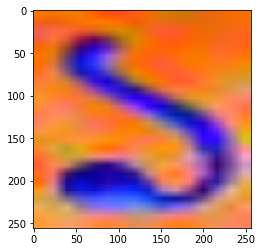

In [33]:
# Size of train and test datasets
#print('No. of samples in train set: '+str(len(trainLoader.dataset)))
#print('No. of samples in test set: '+str(len(testLoader.dataset)))
def show_tensor_img(img):
    #print(im)
    plt.imshow(img.permute(1,2,0))    
    #plt.imshow(img)
    #plt.imshow(im.view(32,32), cmap='gray')
    plt.show()
    
for i, d in enumerate(trainset):
    im, l = d
    print(f'[{i}] label:',l, im.shape)
    show_tensor_img(im)
    
    break

### Define model architecture

In [34]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [35]:
use_gpu = torch.cuda.is_available()
#resnet18 = models.resnet18()
alexnet = models.alexnet()
#vgg16 = models.vgg16()
#squeezenet = models.squeezenet1_0()
#densenet = models.densenet161()
#inception = models.inception_v3()
#googlenet = models.googlenet()
#shufflenet = models.shufflenet_v2_x1_0()
#mobilenet = models.mobilenet_v2()
#resnext50_32x4d = models.resnext50_32x4d()
#wide_resnet50_2 = models.wide_resnet50_2()
#mnasnet = models.mnasnet1_0()
#net = LeNet()
#net = AlexNet()
net = alexnet
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train model

In [36]:
criterion = nn.CrossEntropyLoss() 
#learning_rate_list = [0.001, 0.005, 0.01, 0.05, 0.1]
learning_rate_list = [0.01]
train_acc_list = []
train_loss_list = []
#learning_rate = 0.01
net.train()

for learning_rate in learning_rate_list:
    print(f'\n[*] Training with learning rate: {learning_rate}')
    #Re-initialising the network for fresh training
    #net = LeNet()
    #net = AlexNet()
    num_epochs = 80
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20)
    train_loss = []
    train_acc = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):
            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            #net.zero_grad() 
            optimizer.zero_grad()
            # Data feed-forward through the network
            outputs = net(inputs)
            #outputs = net(inputs).logits
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            loss.backward()
            
            #Batch update
            optimizer.step()
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)    
            #break

        #Epoch update
        #totalLoss = running_loss/(i+1)
        # Calculating gradients
        #totalLoss.backward()
        # Updating the model parameters
        #optimizer.step()
        #for f in net.parameters():
            #f.data.sub_(f.grad.data * learning_rate)
            #print(f.data)

        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/train_sz

        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph

        lr_scheduler.step(epoch_loss)

        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))              
        
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    #plot_Plots(train_loss, train_acc)


[*] Training with learning rate: 0.01
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction
color extraction


KeyboardInterrupt: 

In [41]:
print(labels.shape)

torch.Size([8])


In [ ]:
#To plot the graphs for different hyperparameters [learning rate here] in a loop 
def plot_Plots(train_loss_list, train_acc_list, cmap):
    fig = plt.figure(figsize=[15,5]) 
    #fig = plt.figure(figsize=[30,10])
    plt.subplot(121)
    plt.suptitle(f'Batch Size: {BatchSize}', fontsize=20)
    for idx in range(len(learning_rate_list)):
        plt.plot(range(num_epochs),train_loss_list[idx],cmap[idx],label=f'Loss (lr: {learning_rate_list[idx]})') 
    #plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.subplot(122)
    for idx in range(len(learning_rate_list)):
        plt.plot(range(num_epochs),train_acc_list[idx],cmap[idx],label=f'Accuracy (lr: {learning_rate_list[idx]})') 
    #plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
cmap = ['b','g','r','c','m','y','k','w']
plot_Plots(train_loss_list, train_acc_list,cmap)

### Testing of trained model


In [ ]:
# Testing is being done of best hyperparameter observed from repeated runs
# Best hyperparameter is the last parameter in the list of hyperparams
correct_pred = 0
net.eval()
for i, data in enumerate(testLoader):
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)
    if torch.sum(preds != labels):
        pass
        #print(f'[{i}] Preds: {preds} and labels: {labels}')
        #if i > 20: break

test_accuracy = correct_pred.item()/test_sz
print('[+] Testing accuracy = ',test_accuracy*100)
